## Run SCARlink on example data

This notebook illustrates how to run SCARlink to predict gene expression and visualize output plots. 

#### Preprocessing 

SCARlink requires the file `coassay_matrix.h5` generated using `scarlink_processing`. `scarlink_processing` can be run on Seurat and ArchR objects for scRNA-seq and scATAC-seq respectively. Note that the scRNA-seq and scATAC-seq data sets are multiomic. Gene-specific tile matrices are created for the highly variable genes in the Seurat object that clear the sparsity threshold. For example, if there are 5,000 highly variable genes in the Seurat object and 1,000 genes are above the sparsity threshold, then tile matrices would be created for the 1,000 genes. The sparsity threshold is imposed on gene expression and the default cutoff is that the gene expression vector needs to have < 90% zeros. The tile matrix of each gene comprises of tiles spanning 250kb upstream/downstream and including the gene body. The 250kb window is the default width that can be changed as needed. `scarlink_processing` can be run from the command line as describe in the wiki.


#### Model training

In [1]:
import scarlink as sl
import scarlink.src.visualization as scv

We included a small example data set in the `pbmc_test` directory that was generated using `scarlink_processing`. The example file `coassay_matrix.h5` inside `pbmc_test` contains the tile matrices obtained from 10X PBMC for three genes: _ZEB2_, _HLA-DQB1_, and _CCR7_. Since it is a small enough data set, we can run it inside notebook. However, in general `coassay_matrix.h5` would comprise of numerous genes and would therefore be ideal to run SCARlink in parallel on a compute cluster. See <wiki> for more details.

Note that the output directory needs to be the same for `scarlink_processing`, `scarlink`, and `scarlink_tiles`. In the example data set, the output directory is `pbmc_test`. 

In [2]:
# output directory
outdir = "pbmc_test"

SCARlink regression model to predict gene expression is cell-type-agnostic. However, cell-type information is required for visualization of model output, and for prediction of regulatory regions. These clusters must be defined in either the Seurat object or the ArchR object that were used to run `scarlink_processing`. 

In the example data, the cluster annotations are provided under the `celltype` label. Here we train SCARlink and compute the Shapley values for the `celltype` groupings. Note that the grouping parameter `-c` is optional when SCARlink is run for the first time to train the regression models. 

The command following cell is equivalent to running:

    scarlink -o pbmc_test -g hg38
    scarlink -o pbmc_test -g hg38 -c celltype


In [3]:
# This would take a while to run the first time
!scarlink -o pbmc_test -g hg38 -c celltype

Log file: scarlink_log_None_20_06_10_20_09_2023.log


The example data set also has an additional grouping available, called `celltype_level_0`, that is less granular than `celltype` clusters. We can compute the Shapley values for this additional grouping without retraining the regression models. Since the models are already trained, computing the Shapley values are very fast.

In [4]:
# Re-run SCARlink to compute Shapley values for clustering in celltype_level_0
!scarlink -o pbmc_test -g hg38 -c celltype_level_0

Log file: scarlink_log_None_20_06_23_20_09_2023.log


#### Output visualization

Once the regression models are trained and Shapley values are computed, the outputs can be visualized for all available cell groupings. Here we plot the output for groupings in `celltype` and `celltype_level_0`.

In [5]:
scarlink_out = scv.get_scarlink_output(outdir)

Saved as pbmc_test/scarlink_plots/ZEB2.png


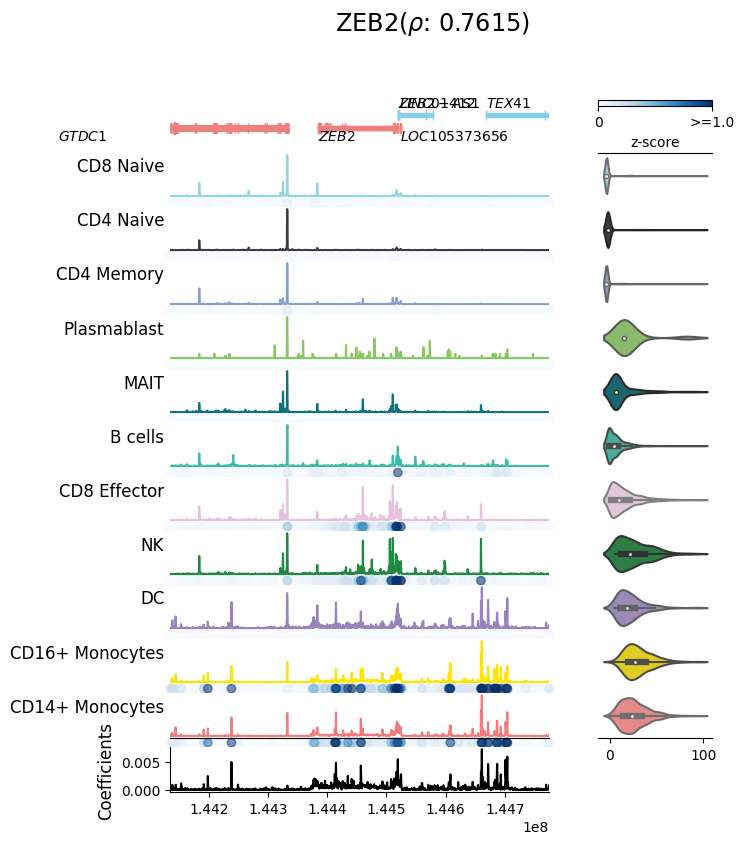

In [6]:
scv.plot_scarlink_output(scarlink_out, genes=['ZEB2'], celltype='celltype', figsize=(7, 9)) # (8, 13))

Saved as pbmc_test/scarlink_plots/ZEB2.png


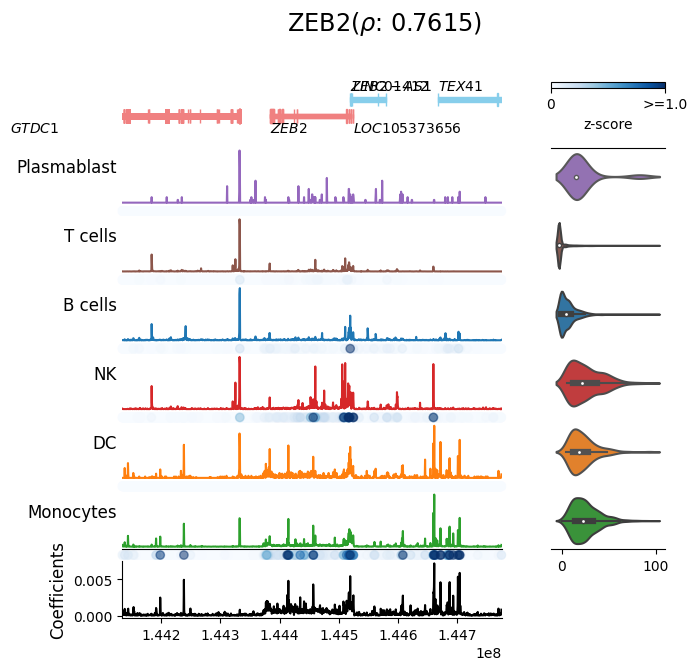

In [7]:
scv.plot_scarlink_output(scarlink_out, genes=['ZEB2'], celltype='celltype_level_0', figsize=(7, 7))

The output plots above for _ZEB2_ with different groupings by `celltype` and `celltype_level_0` show how resolution affects the prediction of gene-linked tiles. The Shapley values converted to z-score depicted by blue dots are an estimate of predicted gene-tile linkage. The `celltype_level_0` grouping does not split the T cells and monocytes into the subtypes. On the other hand, the `celltype` groupings are more granular. The T cells are split into CD4 naive, CD8 naive, CD4 memory, and CD8 effector. The monocytes are split into CD14+ monocytes and CD16+ monocytes. 

For `celltype` groupings, the _ZEB2_ promoter region is accessible in CD8 effector cells and is associated with higher Shapley values compared to other T cell subtypes. When Shapley values are computed for all T cells in aggregate, as in the case of `celltype_level_0`, this linkage prediction is no longer available.

Next, we plot the output of _HLA-DQB1_ and _CCR7_ for `celltype` groupings. 

Saved as pbmc_test/scarlink_plots/HLA-DQB1.png


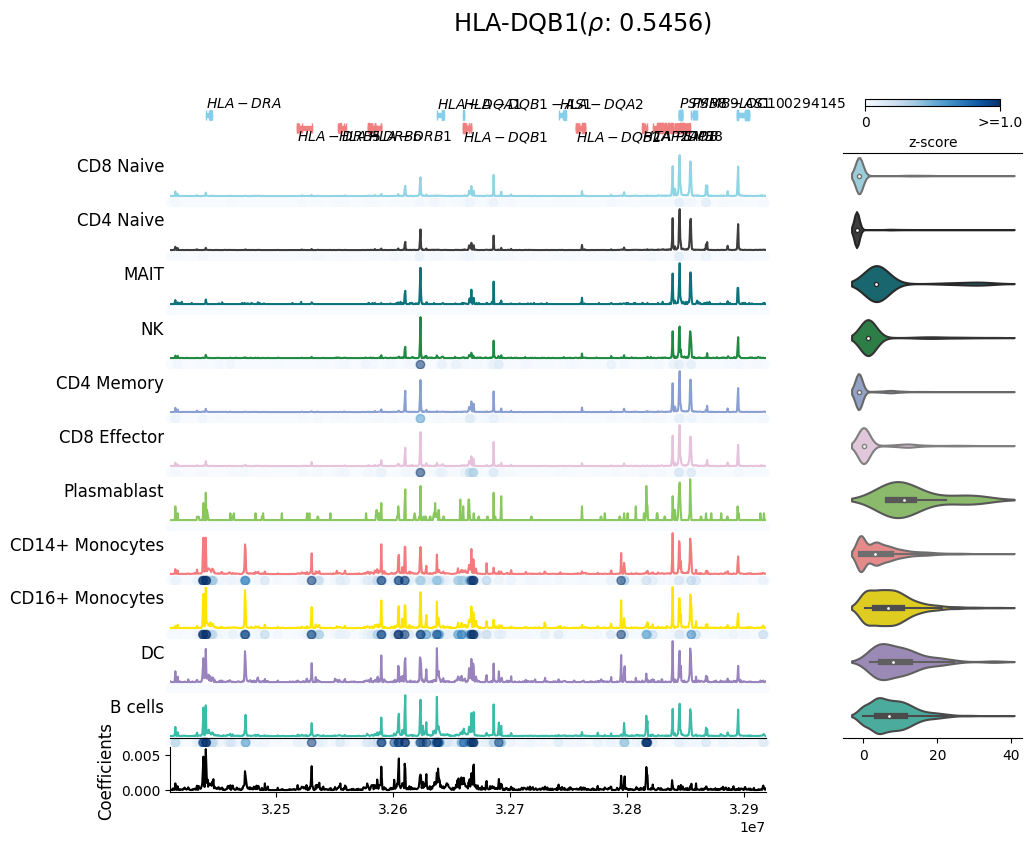

In [8]:
scv.plot_scarlink_output(scarlink_out, genes=['HLA-DQB1'], celltype='celltype', figsize=(11, 9))

Saved as pbmc_test/scarlink_plots/CCR7.png


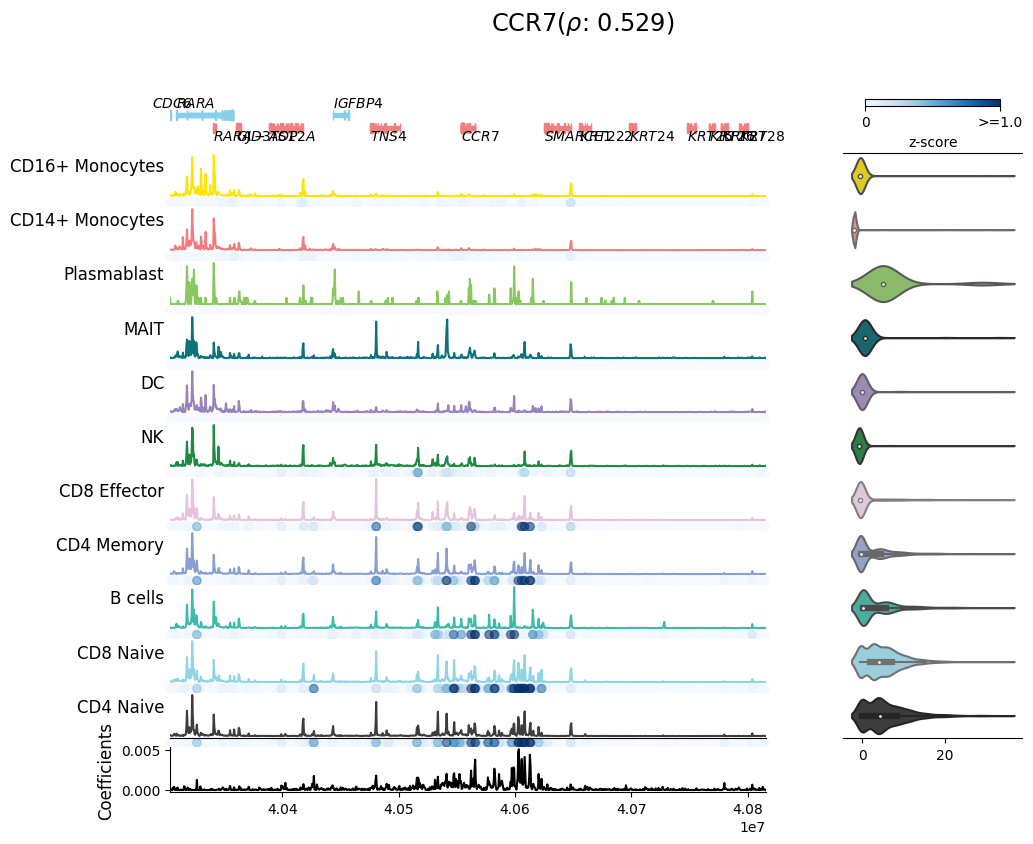

In [9]:
scv.plot_scarlink_output(scarlink_out, genes=['CCR7'], celltype='celltype', figsize=(11, 9))

### Enhancer prediction

After estimating the Shapley values, we estimate the significance of the difference in gene expression prediction on making a tile inaccessible in a given cell type. FDR correction is then performed using Benjamini/Hochberg. Therefore, for each tile associated in a gene and a given celltype annotation, there is an associated z-score and FDR value. The FDR cutoffs are more appropriate for ordering the gene-linked tiles across all genes and celltypes. 

It is recommended to first extract gene-linked tiles based on a z-score cutoff and then use the FDR values to order the predictions. In the SCARlink paper, we used cutoffs z-score > 0.5 and FDR < 1e-3. But these cutoffs can be adjusted as needed.

### Running `scarlink_tiles`

`scarlink_tiles` aggregates the z-scores and p-values for each gene-linked tile in a cell-type-specific manner and performs FDR correction. This generates a CSV file with z-scores and FDR for each gene-linked tile and for every celltype annotation. This can be run for each available cell-grouping. In case of the example data set, the two available groupings are `celltype` and `celltype_level_0`.

In [10]:
# Aggregating gene-linked tiles based on celltype grouping
!scarlink_tiles -o pbmc_test -c celltype

Saved output: pbmc_test/gene_linked_tiles_celltype.csv.gz
Closing remaining open files:pbmc_test/coassay_matrix.h5...done


In [11]:
# Aggregating gene-linked tiles based on celltype_level_0 grouping
!scarlink_tiles -o pbmc_test -c celltype_level_0

Saved output: pbmc_test/gene_linked_tiles_celltype_level_0.csv.gz
Closing remaining open files:pbmc_test/coassay_matrix.h5...done


In [12]:
import pandas
celltype_df = pandas.read_csv("pbmc_test/gene_linked_tiles_celltype.csv.gz", sep='\t')
celltype_level_0_df = pandas.read_csv("pbmc_test/gene_linked_tiles_celltype_level_0.csv.gz", sep='\t')

In [13]:
celltype_df.head()

,chr,start,end,test_acc,test_acc_sparsity,celltype,z-score,p-value,gene,Spearman corr,FDR
0,chr17,40303500,40304000,0.002247,0.011416,B cells,0.026437,1.0,CCR7,0.529042,1.0
1,chr17,40304000,40304500,0.001081,0.005497,B cells,0.000000,1.0,CCR7,0.529042,1.0
2,chr17,40304500,40305000,0.000899,0.004651,B cells,0.000000,1.0,CCR7,0.529042,1.0
3,chr17,40305000,40305500,0.001637,0.005074,B cells,0.000000,1.0,CCR7,0.529042,1.0
4,chr17,40305500,40306000,0.000694,0.002114,B cells,0.000000,1.0,CCR7,0.529042,1.0


In [14]:
celltype_level_0_df.head()

,chr,start,end,test_acc,test_acc_sparsity,celltype_level_0,z-score,p-value,gene,Spearman corr,FDR
0,chr17,40303500,40304000,0.002247,0.011416,B cells,0.063068,1.0,CCR7,0.529042,1.0
1,chr17,40304000,40304500,0.001081,0.005497,B cells,0.000000,1.0,CCR7,0.529042,1.0
2,chr17,40304500,40305000,0.000899,0.004651,B cells,0.037792,1.0,CCR7,0.529042,1.0
3,chr17,40305000,40305500,0.001637,0.005074,B cells,0.037131,1.0,CCR7,0.529042,1.0
4,chr17,40305500,40306000,0.000694,0.002114,B cells,0.037792,1.0,CCR7,0.529042,1.0


In [15]:
# check cluster groupings for both annotations
celltype_df['celltype'].unique(), celltype_level_0_df['celltype_level_0'].unique()

(array(['B cells', 'CD14+ Monocytes', 'CD16+ Monocytes', 'CD4 Memory',
        'CD4 Naive', 'CD8 Effector', 'CD8 Naive', 'DC', 'MAIT', 'NK',
        'Plasmablast'], dtype=object),
 array(['B cells', 'DC', 'Monocytes', 'NK', 'Plasmablast', 'T cells'],
       dtype=object))